In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import adjustText as at
from adjustText import adjust_text

demos = pd.read_csv("demos.csv")
matches = pd.read_csv("matches.csv")
players = pd.read_csv("players.csv")
teams = pd.read_csv("teams.csv")

In [50]:
teams_team_names = sorted(teams['team_name'].unique())
demos_team_names = sorted(demos['team_name'].unique())
players_team_names = sorted(players['team'].unique())

pd.DataFrame({
    'teams': teams_team_names,
    'demos': demos_team_names,
    'players': players_team_names
})

union_ser = pd.Series(np.union1d(teams_team_names, demos_team_names))
intersection_ser = pd.Series(np.intersect1d(teams_team_names, demos_team_names))
differences = union_ser[~union_ser.isin(intersection_ser)]

teams['team_name'] = teams['team_name'].replace('BC.Game', 'BCG')
teams['team_name'] = teams['team_name'].replace('FaZe', 'FaZe Clan')
teams['team_name'] = teams['team_name'].replace('Falcons', 'Team Falcons')
teams['team_name'] = teams['team_name'].replace('G2', 'G2 Esports')
teams['team_name'] = teams['team_name'].replace('Legacy', 'LEGACY')
teams['team_name'] = teams['team_name'].replace('Liquid', 'Team Liquid')
teams['team_name'] = teams['team_name'].replace('Lynn Vision', 'Lynn Vision Gaming')
teams['team_name'] = teams['team_name'].replace('Vitality', 'Team Vitality')

players['team'] = players['team'].replace('BC.Game', 'BCG')
players['team'] = players['team'].replace('FaZe', 'FaZe Clan')
players['team'] = players['team'].replace('Falcons', 'Team Falcons')
players['team'] = players['team'].replace('G2', 'G2 Esports')
players['team'] = players['team'].replace('Legacy', 'LEGACY')
players['team'] = players['team'].replace('Liquid', 'Team Liquid')
players['team'] = players['team'].replace('Lynn Vision', 'Lynn Vision Gaming')
players['team'] = players['team'].replace('Vitality', 'Team Vitality')

teams_team_names = teams['team_name'].unique()
demos_team_names = demos['team_name'].unique()
players_team_names = players['team'].unique()

union_ser = pd.Series(np.union1d(teams_team_names, demos_team_names))
intersection_ser = pd.Series(np.intersect1d(teams_team_names, demos_team_names))
differences = union_ser[~union_ser.isin(intersection_ser)]

demos_player_names = demos['player_name'].unique()
players_player_names = players['name'].unique()

union_ser = pd.Series(np.union1d(players_player_names, demos_player_names))
intersection_ser = pd.Series(np.intersect1d(players_player_names, demos_player_names))
differences = union_ser[~union_ser.isin(intersection_ser)]

demos_player_names = pd.Series(demos['player_name'].unique())
players_player_names = pd.Series(players['name'].unique())

demos_player_names = demos_player_names[demos_player_names.isin(differences)]
players_player_names = players_player_names[players_player_names.isin(differences)]

pd.DataFrame({'demos': demos_player_names, 'players': players_player_names})

players['name'] = players['name'].replace('910', '910-')
players['name'] = players['name'].replace('HeavyGod', 'HeavyGoD')
players['name'] = players['name'].replace('mzinho', 'Mzinho')
players['name'] = players['name'].replace('skullz', 'Skullz')
players['name'] = players['name'].replace('Techno', 'Techno4K')
players['name'] = players['name'].replace('Westmelon', 'westmelon')
players['name'] = players['name'].replace('z4kr', 'z4KR')

demos_player_names = demos['player_name'].unique()
players_player_names = players['name'].unique()

union_ser = pd.Series(np.union1d(players_player_names, demos_player_names))
intersection_ser = pd.Series(np.intersect1d(players_player_names, demos_player_names))
differences = union_ser[~union_ser.isin(intersection_ser)]

demos['player_loadout_array'] = demos['player_loadout'].str.split(', ')
unique_items = demos['player_loadout_array'].explode().unique().tolist()
knives = [i for i in unique_items if
          "knife" in i.lower() or
          "daggers" in i.lower() or
          "bayonet" in i.lower() or
          "karambit" in i.lower()]

demos['player_loadout_array'] = demos['player_loadout_array'].apply(lambda l: [i for i in l if i not in knives])
demos['player_loadout_array'].head(10)

demos = demos[demos['map_id'] != 60]

In [51]:
from scipy.stats import chi2_contingency, chi2
import numpy as np

def perform_chi_squared_test(contingency_table, test_name):
    """
    Perform chi-squared test and display results with interpretation
    """
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    
    n = contingency_table.sum()
    cramers_v = np.sqrt(chi2_stat / (n * (min(contingency_table.shape) - 1)))
    
    print(f"\n=== {test_name} ===")
    print(f"Chi-squared statistic: {chi2_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Degrees of freedom: {dof}")
    print(f"Cramér's V (effect size): {cramers_v:.4f}")
    
    alpha = 0.05
    if p_value < alpha:
        print(f"SIGNIFICANT (p < {alpha}): There IS a statistically significant association")
    else:
        print(f"NOT SIGNIFICANT (p >= {alpha}): There is NO statistically significant association")
    
    if cramers_v < 0.1:
        effect_size = "negligible"
    elif cramers_v < 0.3:
        effect_size = "small"
    elif cramers_v < 0.5:
        effect_size = "medium"
    else:
        effect_size = "large"
    
    print(f"Effect size: {effect_size}")
    print(f"Contingency table:")
    print(contingency_table)
    print(f"Expected frequencies:")
    print(expected.round(2))
    
    return chi2_stat, p_value, cramers_v

## First Kill vs Round Win

**Research Question**: Is there an association between which team gets the first kill in a round and their likelihood of winning that round?

**Hypothesis**: The team that gets the first kill should have a significant advantage due to the numerical superiority (5v4 situation).

In [52]:
first_kill_data = demos[demos['round_first_killer'] == True].copy()

first_kill_data['killer_team_side'] = np.where(
    first_kill_data['team_name'] == first_kill_data['round_ct_team'], 
    'CT', 'T'
)

first_kill_data['killer_team_won'] = (
    ((first_kill_data['killer_team_side'] == 'CT') & (first_kill_data['round_result'] == 'CT')) |
    ((first_kill_data['killer_team_side'] == 'T') & (first_kill_data['round_result'] == 'T'))
)

first_kill_rounds = first_kill_data.groupby(['round_id']).agg({
    'killer_team_side': 'first',
    'killer_team_won': 'first'
}).reset_index()

firstkill_win_crosstab = pd.crosstab(first_kill_rounds['killer_team_side'], 
                                    first_kill_rounds['killer_team_won'])

print(f"\nSample size: {len(first_kill_rounds)} rounds with first kill data")
print(f"CT first kills: {firstkill_win_crosstab.loc['CT'].sum()}")
print(f"T first kills: {firstkill_win_crosstab.loc['T'].sum()}")


Sample size: 1406 rounds with first kill data
CT first kills: 799
T first kills: 607


In [53]:
chi2_stat, p_value, cramers_v = perform_chi_squared_test(
    firstkill_win_crosstab.values, 
    "First Kill vs Round Win"
)


=== First Kill vs Round Win ===
Chi-squared statistic: 3.6641
p-value: 0.0556
Degrees of freedom: 1
Cramér's V (effect size): 0.0510
NOT SIGNIFICANT (p >= 0.05): There is NO statistically significant association
Effect size: negligible
Contingency table:
[[227 572]
 [144 463]]
Expected frequencies:
[[210.83 588.17]
 [160.17 446.83]]


In [54]:
ct_firstkill_winrate = firstkill_win_crosstab.loc['CT', True] / firstkill_win_crosstab.loc['CT'].sum()
t_firstkill_winrate = firstkill_win_crosstab.loc['T', True] / firstkill_win_crosstab.loc['T'].sum()

print(f"\nFirst kill advantage:")
print(f"CT first kill win rate: {ct_firstkill_winrate:.3f}")
print(f"T first kill win rate: {t_firstkill_winrate:.3f}")
print(f"Overall first kill advantage: {(ct_firstkill_winrate + t_firstkill_winrate) / 2:.3f}")


First kill advantage:
CT first kill win rate: 0.716
T first kill win rate: 0.763
Overall first kill advantage: 0.739


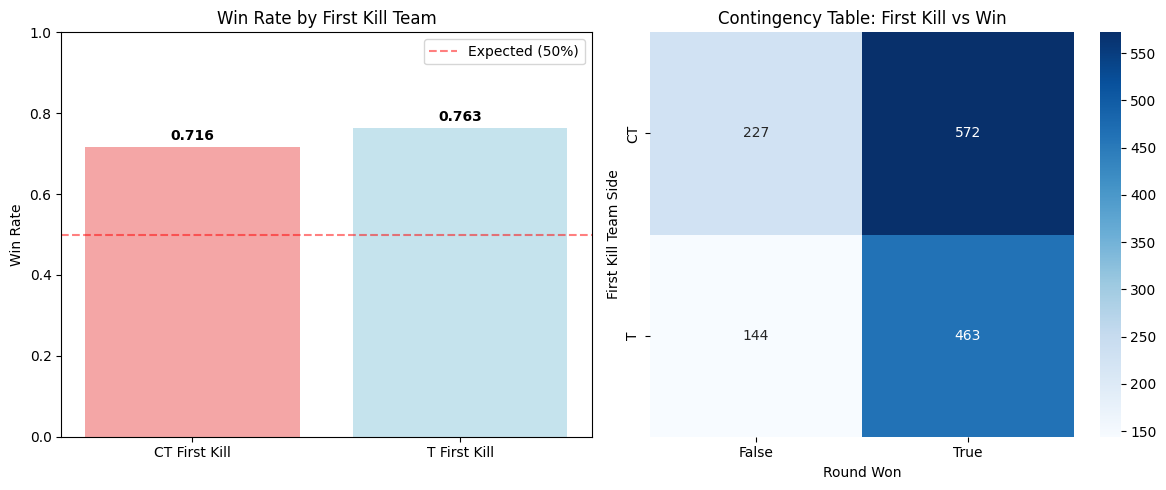

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

teams = ['CT First Kill', 'T First Kill']
win_rates = [ct_firstkill_winrate, t_firstkill_winrate]
bars = ax1.bar(teams, win_rates, color=['lightcoral', 'lightblue'], alpha=0.7)
ax1.set_ylabel('Win Rate')
ax1.set_title('Win Rate by First Kill Team')
ax1.set_ylim(0, 1)
ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Expected (50%)')
ax1.legend()

for bar, rate in zip(bars, win_rates):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{rate:.3f}', ha='center', va='bottom', fontweight='bold')


sns.heatmap(firstkill_win_crosstab, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title('Contingency Table: First Kill vs Win')
ax2.set_xlabel('Round Won')
ax2.set_ylabel('First Kill Team Side')

plt.tight_layout()
plt.show()

## Map vs Round Winner (CT/T Bias)

**Research Question**: Do different maps show bias toward CT or T side wins?

**Hypothesis**: Different maps may have inherent advantages for one side due to map design, angles, and tactical possibilities.

In [58]:
map_rounds = demos.groupby(['round_id']).agg({
    'map_name': 'first',
    'round_result': 'first'
}).reset_index()

map_result_crosstab = pd.crosstab(map_rounds['map_name'], 
                                 map_rounds['round_result'])

print(f"\nSample size: {len(map_rounds)} total rounds")
print("Rounds per map:")
for map_name in map_result_crosstab.index:
    total_rounds = map_result_crosstab.loc[map_name].sum()
    ct_wins = map_result_crosstab.loc[map_name, 'CT']
    ct_rate = ct_wins / total_rounds
    print(f"{map_name}: {total_rounds} rounds, CT win rate: {ct_rate:.3f}")


Sample size: 1428 total rounds
Rounds per map:
de_ancient: 133 rounds, CT win rate: 0.444
de_anubis: 83 rounds, CT win rate: 0.482
de_dust2: 296 rounds, CT win rate: 0.466
de_inferno: 285 rounds, CT win rate: 0.509
de_mirage: 293 rounds, CT win rate: 0.556
de_nuke: 262 rounds, CT win rate: 0.569
de_train: 75 rounds, CT win rate: 0.400


In [60]:
chi2_stat, p_value, cramers_v = perform_chi_squared_test(
    map_result_crosstab.values, 
    "Map vs Round Winner (CT/T Bias)"
)


=== Map vs Round Winner (CT/T Bias) ===
Chi-squared statistic: 14.5966
p-value: 0.0236
Degrees of freedom: 6
Cramér's V (effect size): 0.1011
SIGNIFICANT (p < 0.05): There IS a statistically significant association
Effect size: small
Contingency table:
[[ 59  74]
 [ 40  43]
 [138 158]
 [145 140]
 [163 130]
 [149 113]
 [ 30  45]]
Expected frequencies:
[[ 67.48  65.52]
 [ 42.11  40.89]
 [150.18 145.82]
 [144.6  140.4 ]
 [148.66 144.34]
 [132.93 129.07]
 [ 38.05  36.95]]


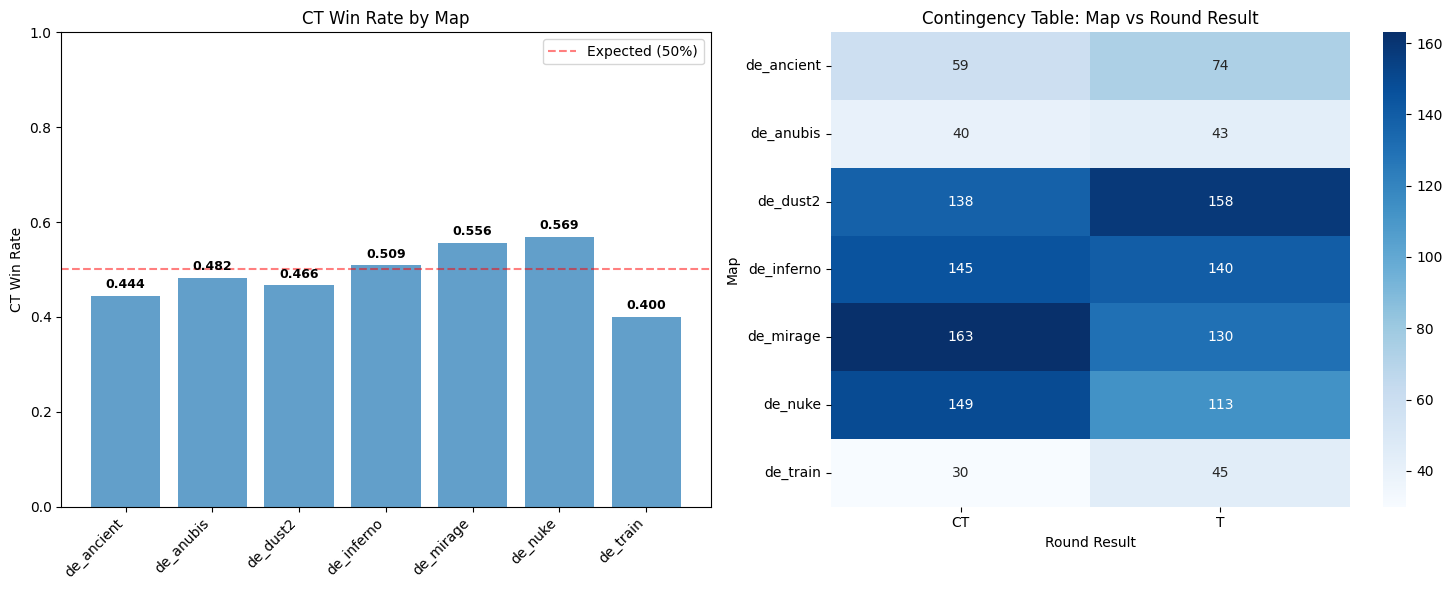

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

maps = map_result_crosstab.index
ct_winrates = []
for map_name in maps:
    total = map_result_crosstab.loc[map_name].sum()
    ct_wins = map_result_crosstab.loc[map_name, 'CT']
    ct_winrates.append(ct_wins / total)

bars = ax1.bar(range(len(maps)), ct_winrates, alpha=0.7)
ax1.set_xticks(range(len(maps)))
ax1.set_xticklabels(maps, rotation=45, ha='right')
ax1.set_ylabel('CT Win Rate')
ax1.set_title('CT Win Rate by Map')
ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Expected (50%)')
ax1.legend()
ax1.set_ylim(0, 1)

for i, (bar, rate) in enumerate(zip(bars, ct_winrates)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{rate:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

sns.heatmap(map_result_crosstab, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title('Contingency Table: Map vs Round Result')
ax2.set_xlabel('Round Result')
ax2.set_ylabel('Map')

plt.tight_layout()
plt.show()

## Pistol Round Win vs Map Performance

**Research Question**: Is there an association between winning pistol rounds (rounds 1 and 16) and overall map performance?

**Hypothesis**: Teams that win pistol rounds should have better overall map performance due to economic advantages and momentum.

In [63]:
team_map_performance = []

for (match_id, map_id), map_data in demos.groupby(['match_id', 'map_id']):
    map_name = map_data['map_name'].iloc[0]
    
    for team in map_data['team_name'].unique():
        team_data = map_data[map_data['team_name'] == team]
        
        team_rounds = team_data.groupby('round_id').agg({
            'round_number': 'first',
            'round_result': 'first',
            'round_ct_team': 'first',
            'team_name': 'first'
        }).reset_index()
        
        team_rounds['team_won'] = (
            ((team_rounds['team_name'] == team_rounds['round_ct_team']) & (team_rounds['round_result'] == 'CT')) |
            ((team_rounds['team_name'] != team_rounds['round_ct_team']) & (team_rounds['round_result'] == 'T'))
        )
        
        # Pistol rounds (1 and 16)
        pistol_rounds = team_rounds[team_rounds['round_number'].isin([1, 16])]
        pistol_wins = pistol_rounds['team_won'].sum()
        
        total_rounds = len(team_rounds)
        total_wins = team_rounds['team_won'].sum()
        
        performance_category = 'Good' if total_wins / total_rounds >= 0.5 else 'Poor'

        pistol_category = 'Won Most' if pistol_wins >= 1 else 'Won None'
        
        team_map_performance.append({
            'match_id': match_id,
            'map_id': map_id,
            'team': team,
            'map_name': map_name,
            'pistol_wins': pistol_wins,
            'pistol_category': pistol_category,
            'total_wins': total_wins,
            'total_rounds': total_rounds,
            'performance_category': performance_category
        })

performance_df = pd.DataFrame(team_map_performance)

pistol_perf_crosstab = pd.crosstab(performance_df['pistol_category'], 
                                  performance_df['performance_category'])

print(f"\nSample size: {len(performance_df)} team-map performances")
print(f"Teams that won most pistols: {pistol_perf_crosstab.loc['Won Most'].sum()}")
print(f"Teams that won no pistols: {pistol_perf_crosstab.loc['Won None'].sum()}")


Sample size: 132 team-map performances
Teams that won most pistols: 101
Teams that won no pistols: 31


In [64]:
chi2_stat, p_value, cramers_v = perform_chi_squared_test(
    pistol_perf_crosstab.values, 
    "Pistol Round Win vs Map Performance"
)


=== Pistol Round Win vs Map Performance ===
Chi-squared statistic: 3.0250
p-value: 0.0820
Degrees of freedom: 1
Cramér's V (effect size): 0.1514
NOT SIGNIFICANT (p >= 0.05): There is NO statistically significant association
Effect size: small
Contingency table:
[[56 45]
 [11 20]]
Expected frequencies:
[[51.27 49.73]
 [15.73 15.27]]


In [65]:
won_most_good = pistol_perf_crosstab.loc['Won Most', 'Good'] / pistol_perf_crosstab.loc['Won Most'].sum()
won_none_good = pistol_perf_crosstab.loc['Won None', 'Good'] / pistol_perf_crosstab.loc['Won None'].sum()

print(f"\nPerformance by pistol success:")
print(f"Teams that won most pistols - good performance rate: {won_most_good:.3f}")
print(f"Teams that won no pistols - good performance rate: {won_none_good:.3f}")
print(f"Difference: {abs(won_most_good - won_none_good):.3f}")


Performance by pistol success:
Teams that won most pistols - good performance rate: 0.554
Teams that won no pistols - good performance rate: 0.355
Difference: 0.200


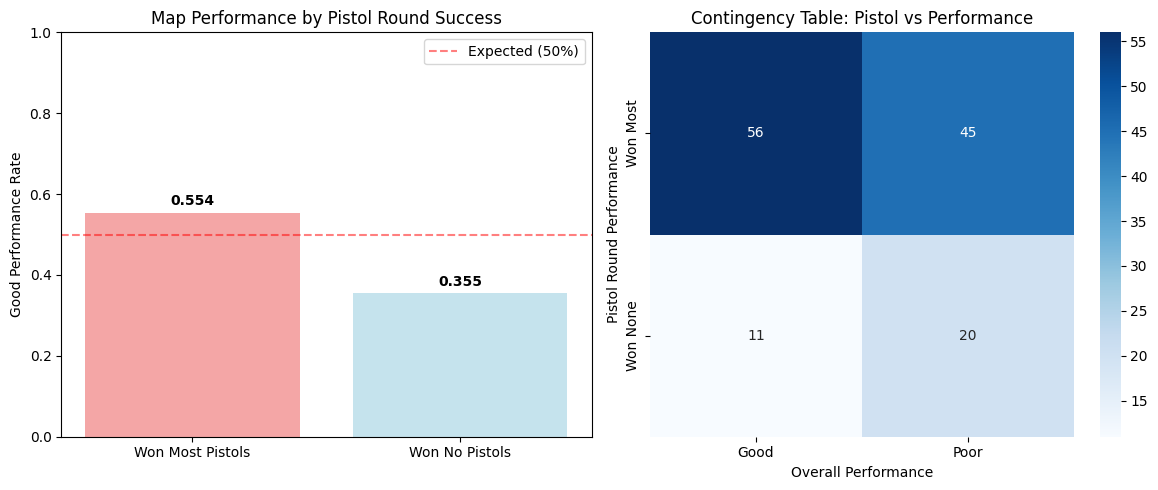

In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

categories = ['Won Most Pistols', 'Won No Pistols']
good_rates = [won_most_good, won_none_good]
bars = ax1.bar(categories, good_rates, color=['lightcoral', 'lightblue'], alpha=0.7)
ax1.set_ylabel('Good Performance Rate')
ax1.set_title('Map Performance by Pistol Round Success')
ax1.set_ylim(0, 1)
ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Expected (50%)')
ax1.legend()

for bar, rate in zip(bars, good_rates):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{rate:.3f}', ha='center', va='bottom', fontweight='bold')

sns.heatmap(pistol_perf_crosstab, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title('Contingency Table: Pistol vs Performance')
ax2.set_xlabel('Overall Performance')
ax2.set_ylabel('Pistol Round Performance')

plt.tight_layout()
plt.show()